<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/eras/eras/tune/programs/0101_newModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通設定

In [1]:
%tensorflow_version 2.x

#ツール

In [23]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

##スクラッチ

In [2]:
del model
keras.backend.clear_session()
gc.collect()

NameError: ignored

#ディレクトリ環境設定

import

In [3]:
# file dealing
import os
from os import path
import shutil
from google.colab import drive
# data dealing
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc

# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks

# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical


In [4]:
def make_dirStruct():
  # gdrive 接続
  if not path.exists('/content/drive'):
    drive.mount('/content/drive')
  else:
    print("Already confirm")
  # colab テンポラリディレクトリの作成
  desk = '/content/desk'
  if not os.path.exists(desk):
    os.mkdir(desk)
  os.chdir(desk)
  print("Created at /content/desk")
  return desk

In [5]:
desk = make_dirStruct()

Mounted at /content/drive
Created at /content/desk


# データフォーマットを規定

In [6]:
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLORinfo = 3 # "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

format1 = video_format()

#データをインポート

In [7]:
#@title 必要なファイルを'desk'にコピー
%%time
wants_paths = [
"/content/drive/MyDrive/colab/data0110/normalTestLabels.npz",
"/content/drive/MyDrive/colab/data0110/normalTestVideos.npz",
"/content/drive/MyDrive/colab/data0110/normalTrainLabels.npz",
"/content/drive/MyDrive/colab/data0110/normalTrainVideos.npz",
]

for want in wants_paths:
  if not os.path.exists(os.path.join(desk, os.path.basename(want))):
    shutil.copy2(want, desk)
    print("get : ", want)
            

get :  /content/drive/MyDrive/colab/data0110/normalTestLabels.npz
get :  /content/drive/MyDrive/colab/data0110/normalTestVideos.npz
get :  /content/drive/MyDrive/colab/data0110/normalTrainLabels.npz
get :  /content/drive/MyDrive/colab/data0110/normalTrainVideos.npz
CPU times: user 36 ms, sys: 186 ms, total: 222 ms
Wall time: 3.73 s


In [8]:
def prepare_data():
  # traindata
  v = np.load('/content/desk/normalTrainVideos.npz')
  l = np.load('/content/desk/normalTrainLabels.npz')

  train_videos = [] 
  train_labels = []
  for i in v.files:
    train_videos.append(v[i])
  for i in l.files:
    train_labels.append(l[i])

  train_videos = np.array(train_videos)
  train_labels = np.array(train_labels)
  train_labels = tf.keras.utils.to_categorical(train_labels, 4)

  # testdata
  v = np.load('/content/desk/normalTestVideos.npz')
  l = np.load('/content/desk/normalTestLabels.npz')

  test_videos = []
  test_labels = []
  for i in v.files:
    test_videos.append(v[i])
  for i in l.files:
    test_labels.append(l[i])

  test_videos = np.array(test_videos)
  test_labels = np.array(test_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels, 4)
  
  return train_videos, train_labels,  test_videos, test_labels

In [9]:
train_videos, train_labels,  test_videos, test_labels = prepare_data()

In [14]:
one = train_videos[0]

print(one.shape)
print(len(train_videos))
print(len(train_labels))
print(len(test_videos))
print(len(test_labels))

(324000,)
104
104
8
8


#モデル作成

In [15]:
seed = 20201218
np.random.seed(seed)
tf.random.set_seed(seed)

In [57]:
# モデル作成
model = models.Sequential()
# 入力層
model.add(
     layers.Reshape(
        (format1.FRAME_SIZE,
         format1.HEIGHT,
         format1.WIDTH,
         format1.COLORinfo),
        input_shape=(format1.FRAME_SIZE * format1.HEIGHT * format1.WIDTH * format1.COLORinfo,),
        name='ENTRANCE' )
)
# 中間層

## 畳み込み_0
h = 2 
w = 3 
d = 3 
model.add(
    layers.Conv3D(
        filters=64,
        kernel_size=(h, w, d),
        strides=(h, w, d),
        padding='same',
        activation='relu',
        name='conv_0'))
## pool_0
model.add(
    layers.MaxPooling3D(pool_size=(1, 1, 3), name='pool_0'))


## 全結合0
model.add(
    layers.Flatten(name='pipe'),
)
# model.add(
#     layers.Dense(64,
#       activation='relu',
#       name='Check1' ),
# )
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
    

## product
model.add(
    layers.Dense(2, activation='softmax', name='product')
)

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# 出力層
model.add(
    layers.Dense(4, activation='softmax', name='WATERSUPPLY')
)

# 最適化
adam = keras.optimizers.Adam(
    lr=1e-4, beta_1=0.9, beta_2=0.999,
    epsilon=None, decay=0.0, amsgrad=False)
# 誤差関数
mse = tf.keras.losses.MeanSquaredError()
cce = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=adam,
    loss=cce,
    metrics=['acc'])

#学習実行

In [17]:
def plot(history):
  HEIGHT = 2
  WIDTH = 2

  # 下地の用意
  fig = plt.figure()
  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1)
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2)
  LOSSDIF = fig.add_subplot(HEIGHT, WIDTH, 3)
  plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=0.5, hspace=0.5)

  # 1,1 loss
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  loss_props = {
        'title' : 'LOSS',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')

  # 1,2 acc
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  acc_props = {
        'title' : 'ACCURACY',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')

  #2,1 loss.diff
  loss_diff_props = {
      'title' : 'loss_diff',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSSDIF.set(**loss_diff_props)
  LOSSDIF.plot(loss.diff(), label='loss_diff', color='blue')
  LOSSDIF.plot(val_loss.diff(), label='val_loss_diff', color='orange')
  LOSSDIF.plot(val_loss.diff())
  

  #save
  name = 'tmp'
  path_image = os.path.join(desk, name)
  fig.savefig(path_image)


Epoch 1/512
4/4 [==============================] - 1s 95ms/step - loss: 1.3893 - acc: 0.1163 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 2/512
4/4 [==============================] - 0s 43ms/step - loss: 1.3799 - acc: 0.1341 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 3/512
4/4 [==============================] - 0s 39ms/step - loss: 1.3735 - acc: 0.1486 - val_loss: 1.3864 - val_acc: 0.1250
Epoch 4/512
4/4 [==============================] - 0s 39ms/step - loss: 1.3650 - acc: 0.5754 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 5/512
4/4 [==============================] - 0s 40ms/step - loss: 1.3610 - acc: 0.7764 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 6/512
4/4 [==============================] - 0s 38ms/step - loss: 1.3519 - acc: 0.7910 - val_loss: 1.3868 - val_acc: 0.2500
Epoch 7/512
4/4 [==============================] - 0s 40ms/step - loss: 1.3481 - acc: 0.7577 - val_loss: 1.3871 - val_acc: 0.2500
Epoch 8/512
4/4 [==============================] - 0s 42ms/step - loss: 1.3413 - acc: 0.79

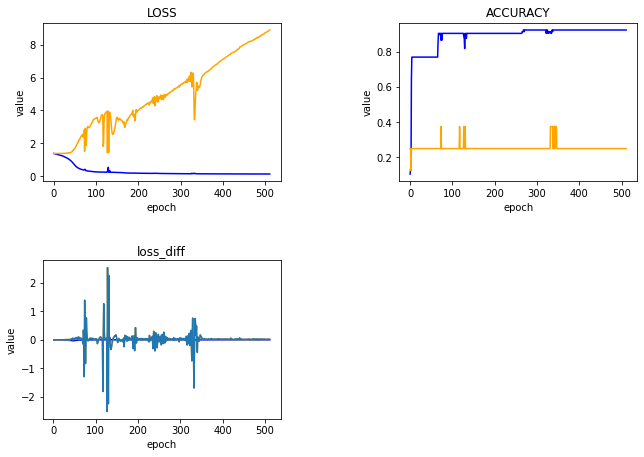

In [58]:
%%time
# 実行
history = model.fit(
      train_videos, train_labels,
      validation_data=(test_videos, test_labels),
      batch_size=32,
      epochs=512,
      # verbose=0
      )

print("Complete.")
# プロット
plot(history)
beep()